<a href="https://colab.research.google.com/github/TryDovick/MosiNLP/blob/main/Lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Этап 1 ыы

In [4]:
pip install pandas

In [17]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_20newsgroups
import re
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import umap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:


# Выбираем 10 случайных категорий из 20
np.random.seed(42)
all_categories = fetch_20newsgroups(subset='all').target_names
selected_categories = np.random.choice(all_categories, size=10, replace=False)

# Загружаем данные только для выбранных категорий
newsgroups = fetch_20newsgroups(
    subset='all',
    categories=selected_categories,
    remove=('headers', 'footers', 'quotes')
)

texts = newsgroups.data
labels = newsgroups.target
label_names = newsgroups.target_names

In [7]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(
    subset='all',
    categories=None,
    remove=('headers', 'footers', 'quotes')
)

texts = newsgroups.data
labels = newsgroups.target
label_names = newsgroups.target_names

In [8]:
import random
from collections import defaultdict

samples_per_class = 50
class_counts = defaultdict(int)
texts_subset = []
labels_subset = []

for text, label in random.sample(list(zip(texts, labels)), len(texts)):
    if class_counts[label] < samples_per_class:
        texts_subset.append(text)
        labels_subset.append(label)
        class_counts[label] += 1
        if len(texts_subset) == samples_per_class * 20:
            break

texts, labels = texts_subset, labels_subset


Лемматизируем текст


In [9]:
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re

# Pre-compile regex and load resources once
STOPWORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()
CLEAN_PATTERN = re.compile(r'[^a-z\s]')

def preprocess(text):
    # Lowercase and clean in one pass
    cleaned = CLEAN_PATTERN.sub('', text.lower())
    # Process words with generator
    words = (word for word in cleaned.split() if len(word) > 2 and word not in STOPWORDS)
    # Lemmatize and join
    return ' '.join(LEMMATIZER.lemmatize(word) for word in words)

In [11]:
clean_texts = list(map(preprocess, texts)) # Очищаем текс

распределение статей по категориям

In [10]:
texts1 = newsgroups.data
labels1 = newsgroups.target
label_names1 = newsgroups.target_names

In [12]:

clean_texts1 = [preprocess(text) for text in texts1]

Общее количество документов: 1000
Количество категорий: 20

Распределение документов по категориям:
alt.atheism: 50 документов
comp.graphics: 50 документов
comp.os.ms-windows.misc: 50 документов
comp.sys.ibm.pc.hardware: 50 документов
comp.sys.mac.hardware: 50 документов
comp.windows.x: 50 документов
misc.forsale: 50 документов
rec.autos: 50 документов
rec.motorcycles: 50 документов
rec.sport.baseball: 50 документов
rec.sport.hockey: 50 документов
sci.crypt: 50 документов
sci.electronics: 50 документов
sci.med: 50 документов
sci.space: 50 документов
soc.religion.christian: 50 документов
talk.politics.guns: 50 документов
talk.politics.mideast: 50 документов
talk.politics.misc: 50 документов
talk.religion.misc: 50 документов


<ipython-input-20-51183c079f80>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


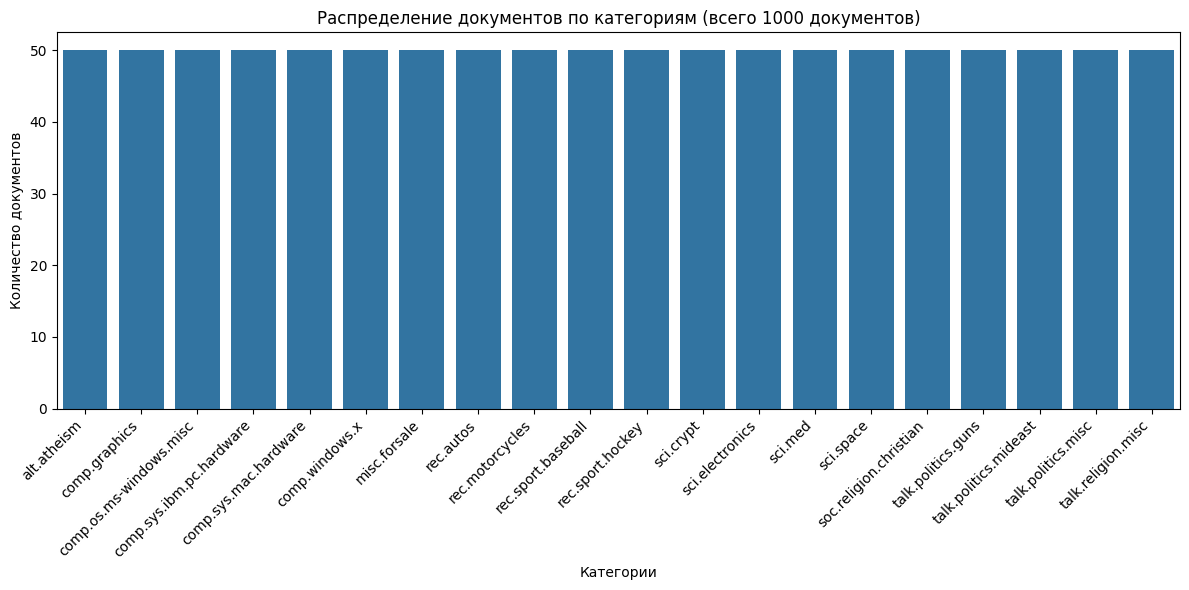

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print(f"Общее количество документов: {len(clean_texts)}")
print(f"Количество категорий: {len(label_names)}")
print("\nРаспределение документов по категориям:")

# Создаем DataFrame
df = pd.DataFrame({
    'Text': clean_texts,
    'Label': labels,
    'Category': [label_names[label] for label in labels]
})

# Получаем уникальные метки и их частоты
label_counts = df['Label'].value_counts().sort_index()

# Выводим статистику
for label, count in label_counts.items():
    print(f"{label_names[label]}: {count} документов")

# Визуализация
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    x='Label',
    data=df,
    order=sorted(df['Label'].unique())  # Сортируем категории
)

# Настраиваем подписи
ax.set_xticklabels(
    [label_names[i] for i in sorted(df['Label'].unique())],
    rotation=45,
    ha='right'
)

plt.title(f"Распределение документов по категориям (всего {len(clean_texts)} документов)")
plt.xlabel("Категории")
plt.ylabel("Количество документов")
plt.tight_layout()
plt.show()


In [21]:

# Векторизация для основного набора данных (10 категорий)
vectorizer = TfidfVectorizer(
    max_features=20000,
    lowercase=True,
    token_pattern=r'\b[a-z]{3,}\b'
)
X = vectorizer.fit_transform(clean_texts)

# Векторизация для полного набора (20 категорий)
X1 = vectorizer.transform(clean_texts1)

print(f"Размерность матрицы для 10 категорий: {X.shape}")
print(f"Размерность матрицы для 20 категорий: {X1.shape}")

Размерность матрицы для 10 категорий: (1000, 19553)
Размерность матрицы для 20 категорий: (18846, 19553)


Кластеризация

In [22]:
kmeans = KMeans(n_clusters=len(label_names1), random_state=42)
clusters = kmeans.fit_predict(X1)

<ipython-input-24-982fde0f4ce8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette='coolwarm')
<ipython-input-24-982fde0f4ce8>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=clusters, palette='viridis')


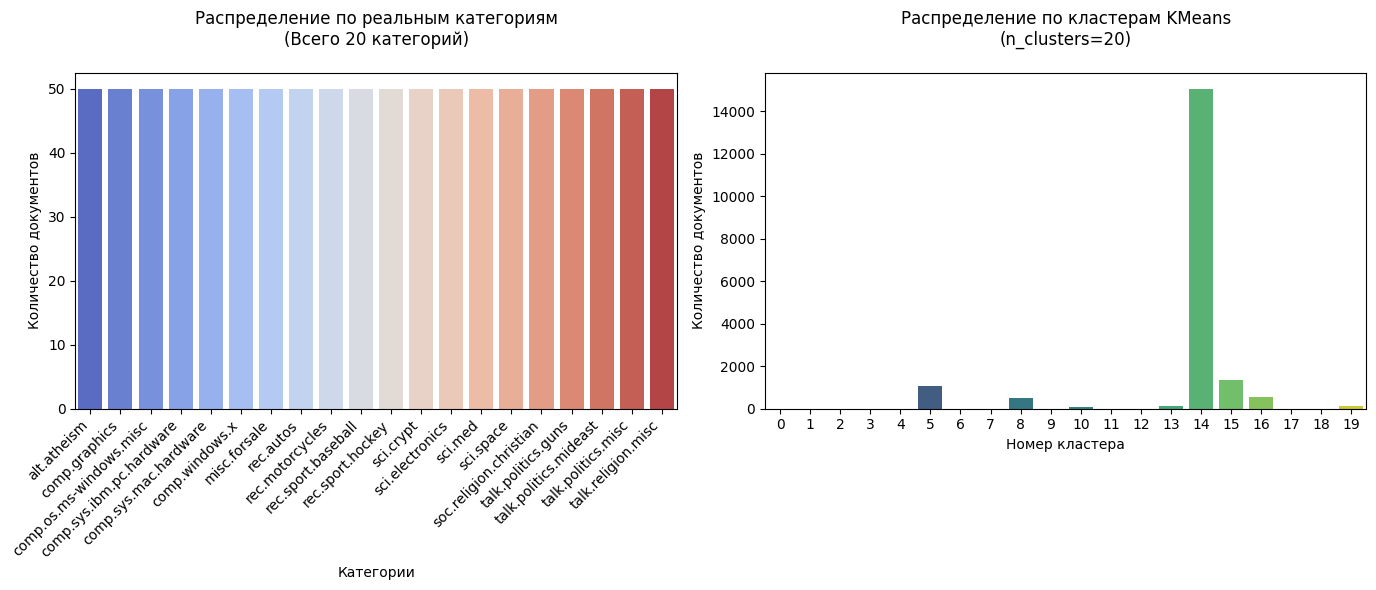

 Метрики качества кластеризации:
Adjusted Rand Index (ARI): 0.0140
   • Интерпретация: 1.0 - полное совпадение с реальными категориями
   • Полученное значение показывает слабое соответствие
 Silhouette Score: -0.0076
   • Интерпретация: от -1 до 1, где 1 - идеальные кластеры
   • Полученное значение указывает на размытые границы кластеров


In [24]:
plt.figure(figsize=(14, 6))

# 1. Распределение по реальным категориям (ваши 10 категорий)
plt.subplot(1, 2, 1)
sns.countplot(x=labels, palette='coolwarm')
plt.title(f"Распределение по реальным категориям\n(Всего {len(label_names)} категорий)", pad=20)
plt.xticks(ticks=range(len(label_names)), labels=label_names, rotation=45, ha='right')
plt.xlabel("Категории")
plt.ylabel("Количество документов")

# 2. Распределение по кластерам (20 категорий)
plt.subplot(1, 2, 2)
sns.countplot(x=clusters, palette='viridis')
plt.title(f"Распределение по кластерам KMeans\n(n_clusters={len(label_names1)})", pad=20)
plt.xlabel("Номер кластера")
plt.ylabel("Количество документов")

plt.tight_layout()
plt.show()

# Метрики качества
ari = adjusted_rand_score(labels1, clusters)  # Сравнение с полным набором (20 категорий)
sil_score = silhouette_score(X1, clusters)

print(" Метрики качества кластеризации:")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"   • Интерпретация: 1.0 - полное совпадение с реальными категориями")
print(f"   • Полученное значение показывает {'хорошее' if ari > 0.5 else 'слабое'} соответствие")
print(f" Silhouette Score: {sil_score:.4f}")
print(f"   • Интерпретация: от -1 до 1, где 1 - идеальные кластеры")
print(f"   • Полученное значение указывает на {'четкие' if sil_score > 0.5 else 'размытые'} границы кластеров")

In [25]:
from sklearn.model_selection import train_test_split

# Разделение данных
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    labels,
    test_size=0.15,
    stratify=labels,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval,
    y_trainval,
    test_size=0.1765,  # 15% от общего объема
    stratify=y_trainval,
    random_state=42
)

# Только основная информация
print(f"Train: {X_train.shape[0]} ({X_train.shape[0]/len(labels):.0%})")
print(f"Val: {X_val.shape[0]} ({X_val.shape[0]/len(labels):.0%})")
print(f"Test: {X_test.shape[0]} ({X_test.shape[0]/len(labels):.0%})")

Train: 699 (70%)
Val: 151 (15%)
Test: 150 (15%)


Этап 2

In [34]:

import evaluate
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments

In [36]:

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Split indices
idx_all = list(range(len(clean_texts)))
idx_trainval, idx_test = train_test_split(
    idx_all,
    test_size=0.15,
    stratify=labels,
    random_state=42
)
idx_train, idx_val = train_test_split(
    idx_trainval,
    test_size=0.1765,
    stratify=[labels[i] for i in idx_trainval],
    random_state=42
)

# Create splits
X_train_texts = [clean_texts[i] for i in idx_train]
y_train = [labels[i] for i in idx_train]

X_val_texts = [clean_texts[i] for i in idx_val]
y_val = [labels[i] for i in idx_val]

X_test_texts = [clean_texts[i] for i in idx_test]
y_test = [labels[i] for i in idx_test]

# Initialize model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_names)
)  # Now properly closed

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
from torch.utils.data import Dataset
import torch

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

    def __len__(self):
        return len(self.labels)

# Создание датасетов
train_dataset = TextDataset(X_train_texts, y_train)
val_dataset = TextDataset(X_val_texts, y_val)
test_dataset = TextDataset(X_test_texts, y_test)

In [43]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    save_total_limit=2,
    fp16=True
)

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
# Подсчет метрик
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=preds, references=labels)

In [ ]:

trainer = Trainer(
model=model,
args=training_args,
train_dataset=train_dataset,
eval_dataset=val_dataset,
compute_metrics=compute_metrics,
)

In [ ]:

trainer.train()

# Новый раздел

In [ ]:

trainer.evaluate(test_dataset)